#Predicting Post Popularity

#### Imports and Helper Functions

In [0]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from sparknlp.pretrained import PretrainedPipeline
!pip install xgboost
from xgboost.spark import SparkXGBClassifier, SparkXGBRegressor
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    cm, 
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize': 20, 'fontweight': 'bold'}, pad=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontdict={'fontsize': 19, 'fontweight': 'bold'})
    plt.xlabel('Predicted label',fontdict={'fontsize': 19, 'fontweight': 'bold'}, labelpad=20)
    
    
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

def BOLD(string):
    return '\033[1m' + string + '\033[0m'

SEED = 42

     |▋                               | 3.5 MB 11.3 MB/s eta 0:00:

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 193.6 MB 27 kB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7b53934a-0549-48bf-8113-37c6891b49e0/bin/python -m pip install --upgrade pip' command.


In [0]:
df = spark.read.parquet("/FileStore/yankees/yankees_df_ml.parquet").cache()
df.limit(5).toPandas()

,num_comments,W/L,comment_length,gilded_cm,controversiality,sentiment_result,score_cm,score,Opp,R,game_length,D/N,attendance,cLI,game_location
0,3598,L,6,0,0,neutral,1,50,TOR,3,3.04,N,1550.0,1.04,home
1,3598,L,225,0,0,negative,8,50,TOR,3,3.04,N,1550.0,1.04,home
2,3598,L,98,0,0,positive,2,50,TOR,3,3.04,N,1550.0,1.04,home
3,3598,L,64,0,0,negative,12,50,TOR,3,3.04,N,1550.0,1.04,home
4,3598,L,190,0,0,negative,5,50,TOR,3,3.04,N,1550.0,1.04,home


##Goal
We will use XGBoost to attempt to predict the number of comments on a post using some -> all of the features listed above. <br>
In doing so we hope to more clearly identify features and combinations of features which are more commonly tied to popular posts.

### Data Cleaning, Preping, and Feature Engineering

target variables:
<li>score_cm - the score on the comment


features:
<li>W/L - the outcome of the Yankees game for the game/game thread (second business question)
<li>num_comments - the number of comments in the game thread (first business question)
<li>controversiality - Number that indicates whether the comment is controversial</li>
<li>sentiment_result - the sentiment of a post as determined by the twitter sentiment analysis model </li>
<li>score- The score that the submission has accumulated. The score is the number of upvotes minus the number of downvotes. </li>
<li>Opp - the team the Yankees played against for a given game thread </li>
<li>R - the number of runs the Yankees scored for that game/game thread</li>
<li>game_length - the length of the Yankees game (in hours)</li>
<li>D/N - denotes whether the Yankees game was played during the day or during the night</li>
<li>attendance - the number of tickets sold for the game</li>
<li>cLI - statistic that denotes that the importance of the game's outcome on the chances of the Yankees winning a world series </li>
<li>game_location - denotes whether the Yankees game was played at home or away

In [0]:
numeric_features     = ['game_length', 'R', 'attendance', 'cLI', 'score', 'num_comments']
categorical_features = ['controversiality', 'W/L', 'sentiment_result', 'Opp', 'D/N', 'game_location']
target = 'score_cm'


## Look for missing data
# df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
## Previously cleaned. No missing data.

## Look at distribution of categorical variables
cats = df.select(categorical_features)
value_counts = []
for col in categorical_features:
    value_counts.append(cats.groupby(col).count().toPandas())
pd.concat(value_counts, axis=1).head()

,controversiality,count,W/L,count,sentiment_result,count,Opp,count,D/N,count,game_location,count
0,0.0,611565.0,L,259225.0,positive,221101.0,NYM,16824,D,182160.0,away,289761.0
1,1.0,7768.0,W,360108.0,neutral,31770.0,OAK,26636,N,437173.0,home,329572.0
2,NaN,NaN,NaN,NaN,negative,366462.0,TBR,81847,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,WSN,11011,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,BAL,66306,NaN,NaN,NaN,NaN


We can see that `controversiality`, `W/L`, `sentiment_result`, `D/N`, and `game_location` all have 2-3 distinct values while `Opp` has as many values <br>
as there are teams in the MLB less the Yankees. While the XGBoost model has its own way of handling categoricals, we may want to encourage <br>
this parameter to be one hot encoded. Integer encoding would imply an ordinality which would be unfair to split on when construting decision trees. <br>
We can thus set the parameter `max_cat_to_onehot` to be a very large value and see how this impacts performance.

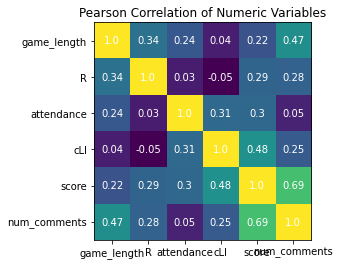

In [0]:
## View numeric variables
# df.select(numeric_features).summary().show()


## View correlation of numeric features.
corrs = float('-inf') * np.ones((len(numeric_features), len(numeric_features)))
for idx_0, col_0 in enumerate(numeric_features):
    for idx_1, col_1 in enumerate(numeric_features):
        corrs[idx_0][idx_1] = df.select(numeric_features).stat.corr(col_0, col_1)
corrs = np.round(corrs, 2)

fig, ax = plt.subplots()
im = ax.imshow(corrs)

## Add dummy for matplotlib
ax.set_xticklabels(labels=['foo'] + numeric_features)
ax.set_yticklabels(labels=['bar'] + numeric_features)

for idx_0, col_0 in enumerate(numeric_features):
    for idx_1, col_1 in enumerate(numeric_features):
        text = ax.text(idx_1, idx_0, corrs[idx_0][idx_1], ha="center", va="center", color="w")

ax.set_title("Pearson Correlation of Numeric Variables")

plt.show()

While some of the features are correlated, they certainly aren't colinear. We can comfortably begin modeling using all varaibles and don't have to resort to <br>
dimensionality reduction techniques like PCA.

### Pipeline + Model Construction
We can now begin to construct our model. As previously mentioned we will begin by attempting to predict a comment's score using the features covered above. <br>
First though we should construct a cross validation and hyperparameter grid search pipeline.

###Regressor Training

In [0]:
## Before we use the vector assembler, we need to map our categorical features to integers.
indexers = [StringIndexer(inputCol=column, outputCol=column + '_') for column in categorical_features]

## vectorAssembler combines all feature columns into a single feature vector column, "rawFeatures".
vectorAssembler = VectorAssembler(inputCols=numeric_features + [x + '_' for x in categorical_features], outputCol="raw_features")
 
## vectorIndexer identifies categorical features and indexes them, and creates a new column "features".
## maxCategories is equivalent to max_cat_to_onehot in XGBoost. Will just do it in pyspark instead.
vectorIndexer = VectorIndexer(inputCol="raw_features", outputCol="features", maxCategories=999)


## Define model
xgb_model = SparkXGBRegressor(
    num_workers=4, 
    label_col=target, 
    missing=float('-inf'),
    max_cat_to_onehot=999 ## As mentioned previously
)

## Hyperparams to search
paramGrid = ParamGridBuilder()\
  .addGrid(xgb_model.max_depth, [5, 8])\
  .addGrid(xgb_model.n_estimators, [10, 250])\
  .build()
 
    
# Define an evaluation metric. The CrossValidator compares the true labels with predicted values for each combination of parameters, and calculates this value to determine the best model.
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol=xgb_model.getLabelCol(),
    predictionCol=xgb_model.getPredictionCol()
)
 
# Declare the CrossValidator, which performs the model tuning.
cv = CrossValidator(
    estimator=xgb_model, 
    evaluator=evaluator, 
    estimatorParamMaps=paramGrid,
    numFolds=4,
    seed=SEED
)

pipeline = Pipeline(stages=indexers + [vectorAssembler, vectorIndexer, cv])

### Model Training

In [0]:
train_df, test_df = df.randomSplit([0.75, 0.25], seed=SEED)

pipelineModel = pipeline.fit(train_df)

# Save the pipeline that created the model
try:
    pipeline.save('/FileStore/trained_models/xgb_pipeline_regressor')
except:
    pass
 
# Save the model itself
try:
    pipelineModel.save('/FileStore/trained_models/xgb_model_regressor')
except:
    pass

###Model Evaluation

In [0]:
## Load best model
pipelineModel.load('/FileStore/trained_models/xgb_model_regressor')

preds = pipelineModel.transform(test_df)

rmse = evaluator.evaluate(preds)
print("RMSE on our test set: %g" % rmse)

RMSE on our test set: 3.3143


###Classifier Training

This model is not very good. This is almost certainly due to large amount of noise in the individual comments and the lack of signal <br>
given by these features. <br>

Perhaps we can reframe this question and attempt to identify comments with a very negative score (< -2) or a very positive score (> 2).

In [0]:
@udf
def map_target(x):
    if x < -2:
        return -1
    elif x > 2:
        return 1
    else:
        return 0
    
_df = df.withColumn(target, map_target(df[target]))

In [0]:
labelIndexer = StringIndexer(inputCol=target, outputCol=target + '_')

## Before we use the vector assembler, we need to map our categorical features to integers.
indexers = [StringIndexer(inputCol=column, outputCol=column + '_') for column in categorical_features]

## vectorAssembler combines all feature columns into a single feature vector column, "rawFeatures".
vectorAssembler = VectorAssembler(inputCols=numeric_features + [x + '_' for x in categorical_features], outputCol="raw_features")
 
## vectorIndexer identifies categorical features and indexes them, and creates a new column "features".
## maxCategories is equivalent to max_cat_to_onehot in XGBoost. Will just do it in pyspark instead.
vectorIndexer = VectorIndexer(inputCol="raw_features", outputCol="features", maxCategories=999)


## Define model
xgb_model = SparkXGBClassifier(
    num_workers=4, 
    label_col=target + '_', 
    missing=float('-inf'),
    max_cat_to_onehot=999 ## As mentioned previously
)

## Hyperparams to search
paramGrid = ParamGridBuilder()\
  .addGrid(xgb_model.max_depth, [5, 8])\
  .addGrid(xgb_model.n_estimators, [10, 250])\
  .build()
 
    
# Define an evaluation metric. The CrossValidator compares the true labels with predicted values for each combination of parameters, and calculates this value to determine the best model.
evaluator = MulticlassClassificationEvaluator(
    metricName="f1",
    labelCol=xgb_model.getLabelCol(),
    predictionCol=xgb_model.getPredictionCol()
)
 
# Declare the CrossValidator, which performs the model tuning.
cv = CrossValidator(
    estimator=xgb_model, 
    evaluator=evaluator, 
    estimatorParamMaps=paramGrid,
    numFolds=4,
    seed=SEED
)

pipeline = Pipeline(stages=[labelIndexer] + indexers + [vectorAssembler, vectorIndexer, cv])

###Training

In [0]:
train_df, test_df = _df.randomSplit([0.75, 0.25], seed=SEED)

pipelineModel = pipeline.fit(train_df)

# Save the pipeline that created the model
try:
    pipeline.save('/FileStore/trained_models/xgb_pipeline_classifier')
except:
    pass

# Save the model itself
try:
    pipelineModel.save('/FileStore/trained_models/xgb_model_classifier')
except:
    pass

###Evaluation

In [0]:
## Load best model

pipelineModel.load('/FileStore/trained_models/xgb_model_regressor')

@udf
def map_targets(x):
    mapping = {
        '-1': 2.0,
        '0': 0.0,
        '1': 1.0
    }
    return mapping[x]


preds   = pipelineModel.transform(test_df)
preds_array = np.array(preds.select('prediction').toPandas()['prediction'])
test_df = test_df.withColumn('true_labels', map_targets(target))
true    = np.array(test_df.select('true_labels').toPandas()['true_labels']).astype(float)

f1 = evaluator.evaluate(preds)
print("F1 on our test set: %g" % f1)

Again this score is not great. It seems that the metadata of the comments and submissions accompanied by real world data (Yankees data) <br>
which the posts/comments reasonably pertain to, is not enough to reliably predict the popularity of a comment. <br><br>

Again this is not too surprising as we can expect there to be a lot of noise in this dataset. Two identical posts in the same thread <br>
could concievably get vastly different scores simply due to randomness. (i.e. one posts gets a high score and gains visibility and thus gets <br>
an even higher score)

In [0]:
cm = confusion_matrix(true, preds_array)
print("Confusion Matrix:")
print(cm)

In [0]:
class_names = ['positive', 'neutral', 'negative']

In [0]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

font = {
    'family' : 'normal',
    'weight' : 'normal',
    'size'   : 18
}

plt.rc('font', **font)

plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix XGBoost', cmap='GnBu')